
# NLP Module Project – The Social Dilemma

This notebook presents a comprehensive analysis of Twitter data associated with the hashtag **#TheSocialDilemma**, which followed the release of the Netflix documentary **“The Social Dilemma”**.  The project objectives are to clean and explore the data, prepare it for modelling, build and evaluate machine‑learning classifiers to predict tweet sentiment, and summarise insights.

The dataset (`TheSocialDilemma.csv`) contains Twitter responses collected via the Twitter API after the documentary’s release.  It includes user information, tweet text and metadata, hashtags, and a manual sentiment label (`Sentiment`).



In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from datetime import datetime

%matplotlib inline
sns.set(style="whitegrid", palette="muted", color_codes=True)

# Load dataset
file_path = '/home/oai/share/TheSocialDilemma.csv'
df = pd.read_csv(file_path)
print('Dataset shape:', df.shape)
df.head()


Dataset shape: (20068, 14)


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,Sentiment
0,Mari Smith,"San Diego, California",Premier Facebook Marketing Expert | Social Med...,2007-09-11 22:22:51,579942,288625,11610,False,2020-09-16 20:55:33,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,NaN,Twitter Web App,False,Neutral
1,Mari Smith,"San Diego, California",Premier Facebook Marketing Expert | Social Med...,2007-09-11 22:22:51,579942,288625,11610,False,2020-09-16 20:53:17,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,NaN,Twitter Web App,False,Neutral
2,Varun Tyagi,"Goa, India",Indian | Tech Solution Artist & Hospitality Ex...,2009-09-06 10:36:01,257,204,475,False,2020-09-16 20:51:57,Go watch “The Social Dilemma” on Netflix!\n\nI...,NaN,Twitter for iPhone,False,Positive
3,Casey Conway,"Sydney, New South Wales",Head of Diversity & Inclusion @RugbyAU | It's ...,2012-12-28 21:45:06,11782,1033,12219,True,2020-09-16 20:51:46,I watched #TheSocialDilemma last night. I’m sc...,['TheSocialDilemma'],Twitter for iPhone,False,Negative
4,Charlotte Paul,Darlington,Instagram Charlottejyates,2012-05-28 20:43:08,278,387,5850,False,2020-09-16 20:51:11,The problem of me being on my phone most the t...,['TheSocialDilemma'],Twitter for iPhone,False,Positive



## 1. Data Analysis

### 1.A Missing value analysis and eliminating non‑English tweets

First we inspect missing values per column and then remove tweets that are likely to be non‑English.  A simple heuristic is used to check the proportion of ASCII characters in the tweet text; tweets where fewer than 90 % of characters are ASCII are dropped.


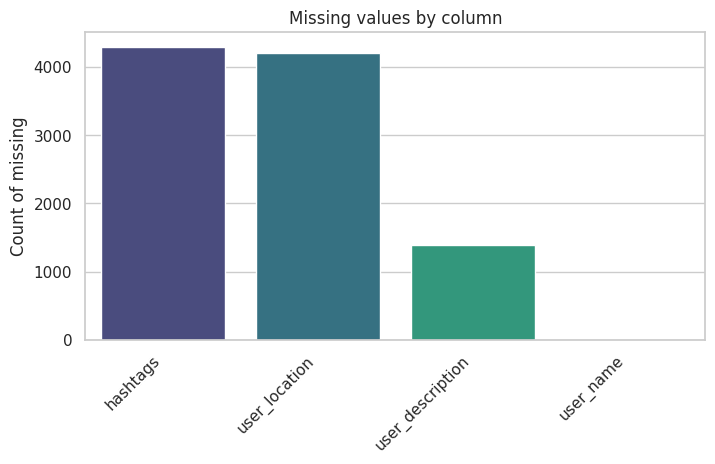

Total tweets before language filter: 20068
Total tweets after language filter: 20005


In [2]:

# Function to plot missing values
def plot_missing_values(df):
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    if missing.empty:
        print("No missing values detected.")
        return
    missing.sort_values(ascending=False, inplace=True)
    plt.figure(figsize=(8,4))
    sns.barplot(x=missing.index, y=missing.values, palette='viridis')
    plt.title('Missing values by column')
    plt.ylabel('Count of missing')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Plot missing values
plot_missing_values(df)

# Eliminate non‑English tweets based on ASCII character proportion
def is_english(text, threshold=0.9):
    if not isinstance(text, str) or len(text) == 0:
        return False
    ascii_count = sum(1 for ch in text if ch.isascii())
    return (ascii_count / len(text)) >= threshold

df['is_english'] = df['text'].apply(is_english)
print('Total tweets before language filter:', len(df))
df = df[df['is_english']].copy()
print('Total tweets after language filter:', len(df))

# Drop the helper column
df.drop(columns=['is_english'], inplace=True)



### 1.B Unique value counts

The next plot shows the number of unique values in each column.  This helps identify categorical columns with high cardinality and decide how to handle them later.


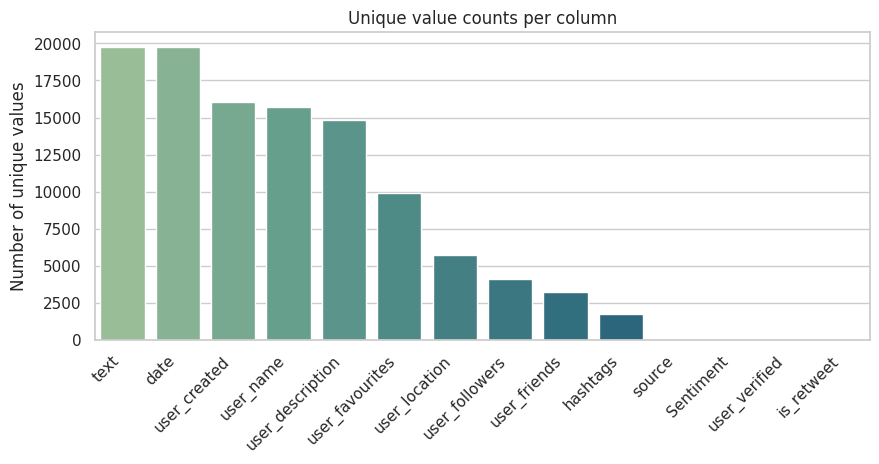

In [3]:

# Function to plot unique value counts
def plot_unique_counts(df):
    unique_counts = df.nunique().sort_values(ascending=False)
    plt.figure(figsize=(10,4))
    sns.barplot(x=unique_counts.index, y=unique_counts.values, palette='crest')
    plt.title('Unique value counts per column')
    plt.ylabel('Number of unique values')
    plt.xticks(rotation=45, ha='right')
    plt.show()

plot_unique_counts(df)



### 1.C Distribution of sentiment labels

We visualise the distribution of sentiment labels to understand the class imbalance in the dataset.


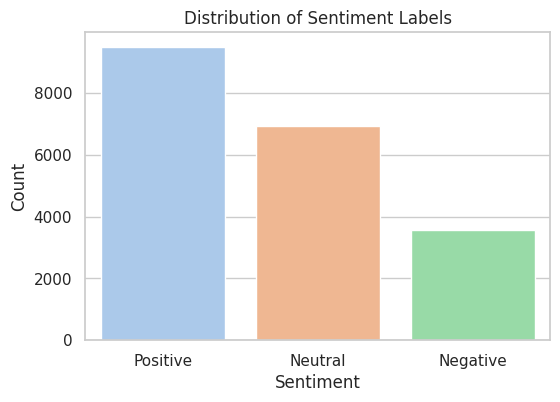

Sentiment
Positive    9493
Neutral     6942
Negative    3570
Name: count, dtype: int64


In [4]:

plt.figure(figsize=(6,4))
sns.countplot(x=df['Sentiment'], order=df['Sentiment'].value_counts().index, palette='pastel')
plt.title('Distribution of Sentiment Labels')
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.show()

print(df['Sentiment'].value_counts())



### 1.D Top users, sources and locations

The following plots identify the top 20 users, sources and user locations by number of tweets.


/opt/pyvenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/pyvenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127474 (\N{REGIONAL INDICATOR SYMBOL LETTER M}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/pyvenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129318 (\N{FACE PALM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/pyvenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127996 (\N{EMOJI MODIFIER FITZPATRICK TYPE-3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/pyvenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2384 (\N{DEVANAGARI OM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt

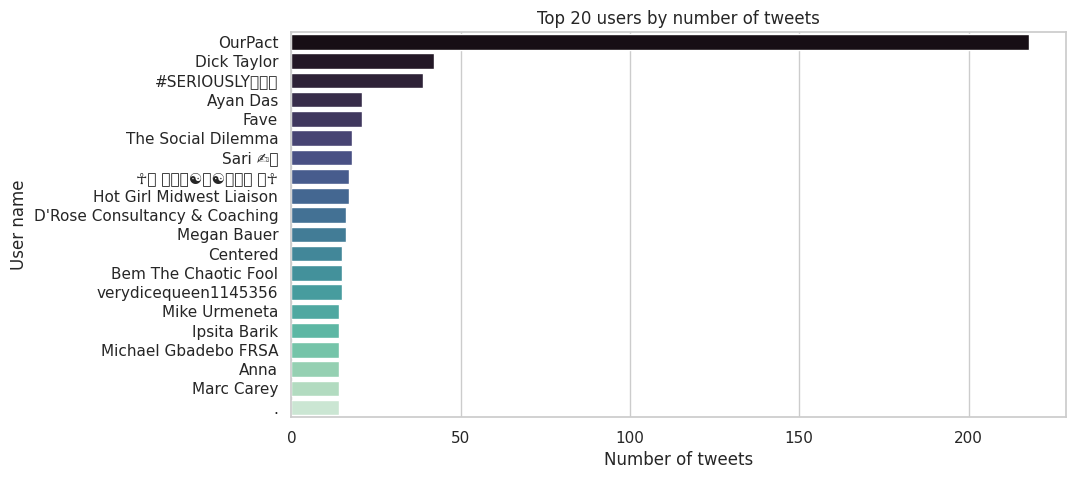

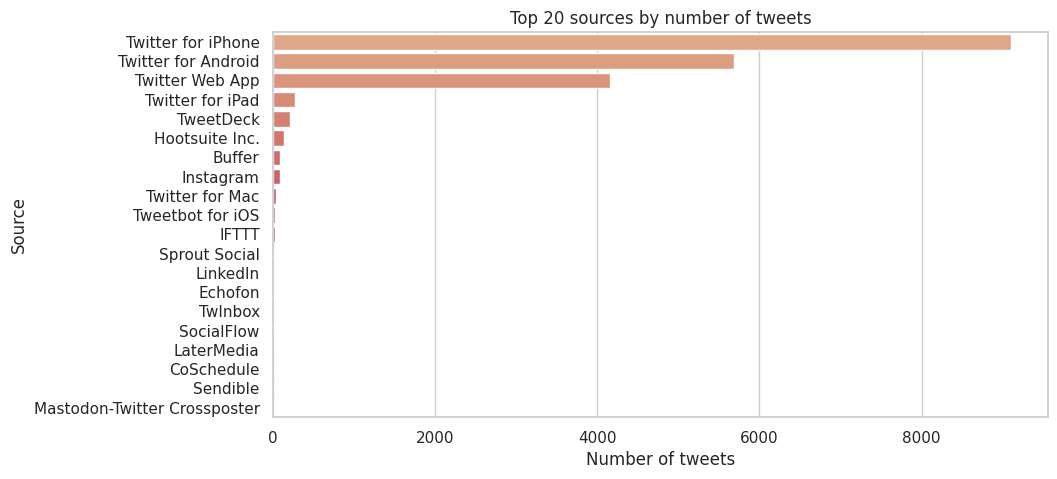

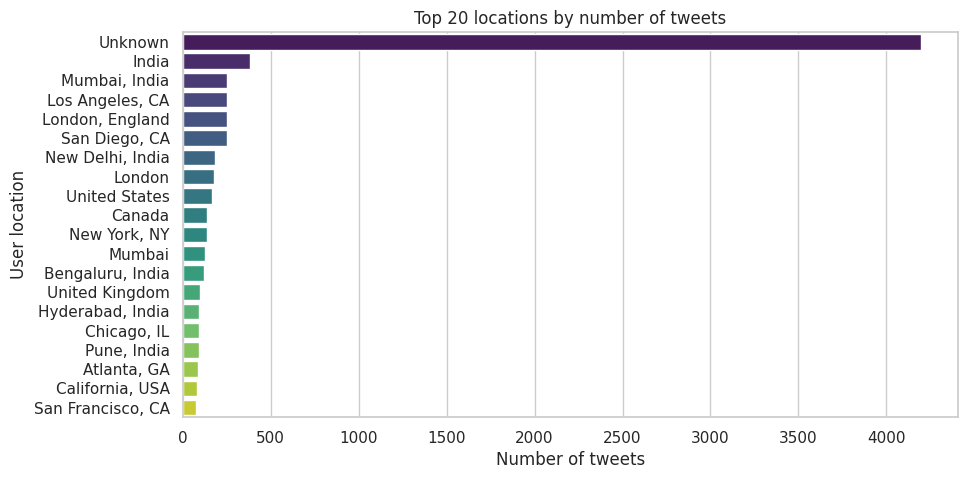

In [5]:

# Top 20 user names
top_users = df['user_name'].value_counts().head(20)
plt.figure(figsize=(10,5))
sns.barplot(y=top_users.index, x=top_users.values, palette='mako')
plt.title('Top 20 users by number of tweets')
plt.xlabel('Number of tweets')
plt.ylabel('User name')
plt.show()

# Top 20 sources
top_sources = df['source'].value_counts().head(20)
plt.figure(figsize=(10,5))
sns.barplot(y=top_sources.index, x=top_sources.values, palette='flare')
plt.title('Top 20 sources by number of tweets')
plt.xlabel('Number of tweets')
plt.ylabel('Source')
plt.show()

# Top 20 user locations
top_locations = df['user_location'].fillna('Unknown').value_counts().head(20)
plt.figure(figsize=(10,5))
sns.barplot(y=top_locations.index, x=top_locations.values, palette='viridis')
plt.title('Top 20 locations by number of tweets')
plt.xlabel('Number of tweets')
plt.ylabel('User location')
plt.show()



### 1.E Standardising top locations and counting tweets

We take the top 50 locations by tweet count and attempt to standardise them into `city, country` format.  Where only a single component is provided it is annotated with an `Unknown` country.  We then plot the tweet counts for the standardised locations.


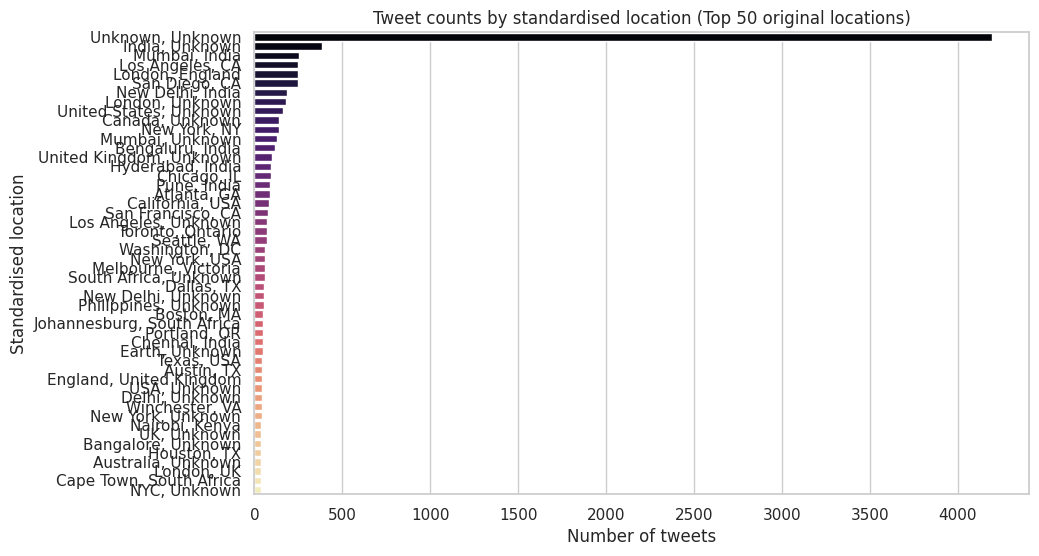

In [6]:

# Take top 50 locations
location_counts = df['user_location'].fillna('Unknown').value_counts().head(50)

# Function to standardise location strings
def standardise_location(loc):
    if pd.isnull(loc) or not str(loc).strip():
        return 'Unknown, Unknown'
    parts = [p.strip() for p in str(loc).split(',') if p.strip()]
    if len(parts) == 0:
        return 'Unknown, Unknown'
    if len(parts) == 1:
        return f"{parts[0]}, Unknown"
    city = parts[0]
    country = parts[-1]
    return f"{city}, {country}"

standardised = location_counts.index.to_series().apply(standardise_location)
std_counts = pd.Series(location_counts.values, index=standardised).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(y=std_counts.index, x=std_counts.values, palette='magma')
plt.title('Tweet counts by standardised location (Top 50 original locations)')
plt.xlabel('Number of tweets')
plt.ylabel('Standardised location')
plt.show()



### 1.G Hashtag counts

We compute the number of hashtags present in each tweet and visualise the distribution.


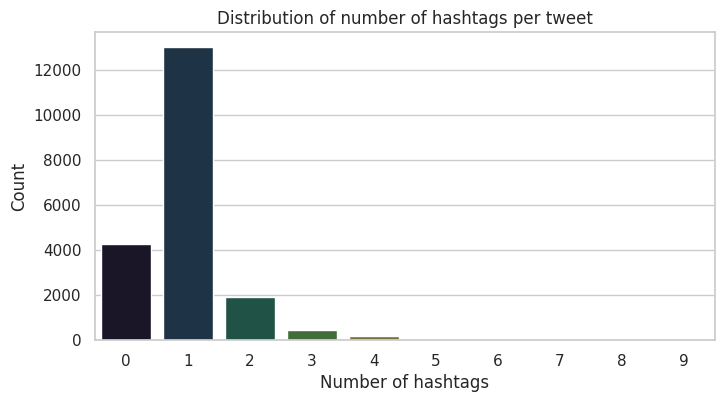

In [7]:

# Count hashtags in each tweet
def count_hashtags(hashtag_str):
    if not isinstance(hashtag_str, str) or hashtag_str.strip() == '':
        return 0
    tags = [tag for tag in hashtag_str.split() if tag]
    return len(tags)

df['num_hashtags'] = df['hashtags'].apply(count_hashtags)

plt.figure(figsize=(8,4))
sns.countplot(x=df['num_hashtags'], palette='cubehelix')
plt.title('Distribution of number of hashtags per tweet')
plt.xlabel('Number of hashtags')
plt.ylabel('Count')
plt.show()



### 1.H Daily and hourly distribution of tweets

We convert the `date` column to a datetime object and compute daily and hourly tweet counts.


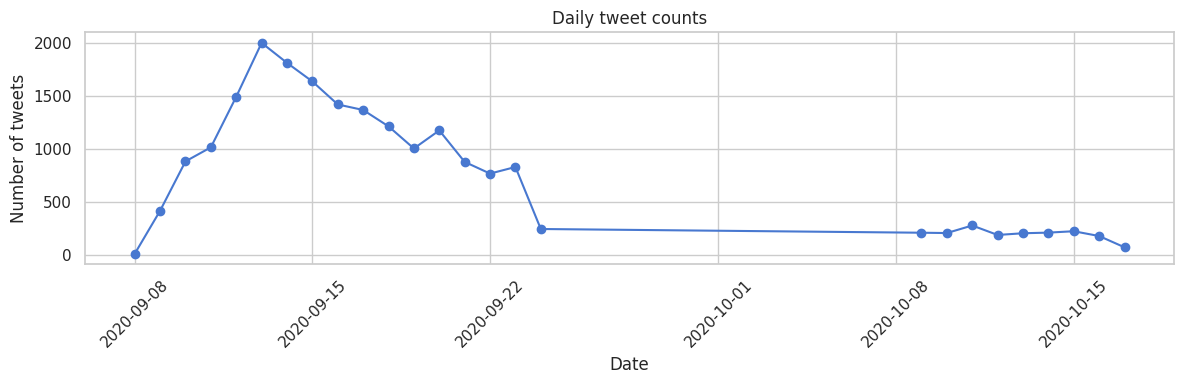

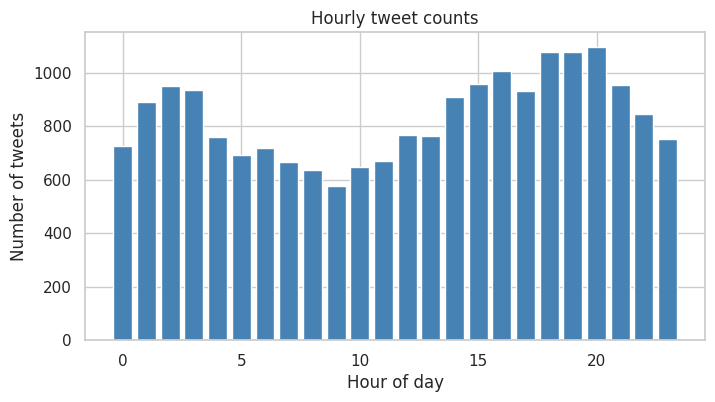

In [8]:

# Convert date column to datetime
df['date_dt'] = pd.to_datetime(df['date'])

# Daily distribution
daily_counts = df['date_dt'].dt.date.value_counts().sort_index()
plt.figure(figsize=(12,4))
plt.plot(daily_counts.index, daily_counts.values, marker='o')
plt.xticks(rotation=45)
plt.title('Daily tweet counts')
plt.xlabel('Date')
plt.ylabel('Number of tweets')
plt.tight_layout()
plt.show()

# Hourly distribution
hourly_counts = df['date_dt'].dt.hour.value_counts().sort_index()
plt.figure(figsize=(8,4))
plt.bar(hourly_counts.index, hourly_counts.values, color='steelblue')
plt.title('Hourly tweet counts')
plt.xlabel('Hour of day')
plt.ylabel('Number of tweets')
plt.show()



### 1.I User account creation year distribution

We examine the number of user accounts created each year to see when accounts in this dataset were registered.


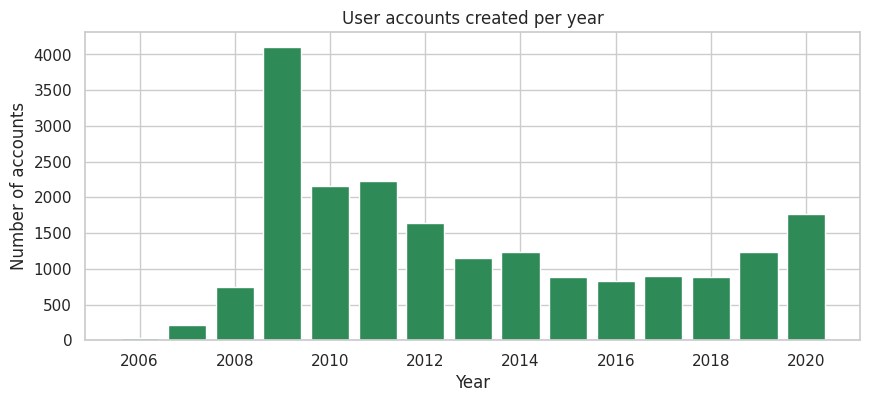

In [9]:

# Convert user_created column to datetime
df['user_created_dt'] = pd.to_datetime(df['user_created'])
df['user_created_year'] = df['user_created_dt'].dt.year

user_creation_counts = df['user_created_year'].value_counts().sort_index()
plt.figure(figsize=(10,4))
plt.bar(user_creation_counts.index, user_creation_counts.values, color='seagreen')
plt.title('User accounts created per year')
plt.xlabel('Year')
plt.ylabel('Number of accounts')
plt.show()



### 1.J Top 10 hashtags used

We aggregate all hashtags into a single list, clean the entries and identify the top 10 hashtags across the dataset.


Top 10 hashtags: [('TheSocialDilemma', 14530), ('Netflix', 843), ('thesocialdilemma', 578), ('netflix', 186), ('socialmedia', 150), ('SocialMedia', 99), ('Facebook', 74), ('TheGreatHack', 53), ('socialdilemma', 52), ('documentary', 45)]


/opt/pyvenv/lib/python3.11/site-packages/seaborn/_core.py:1485: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


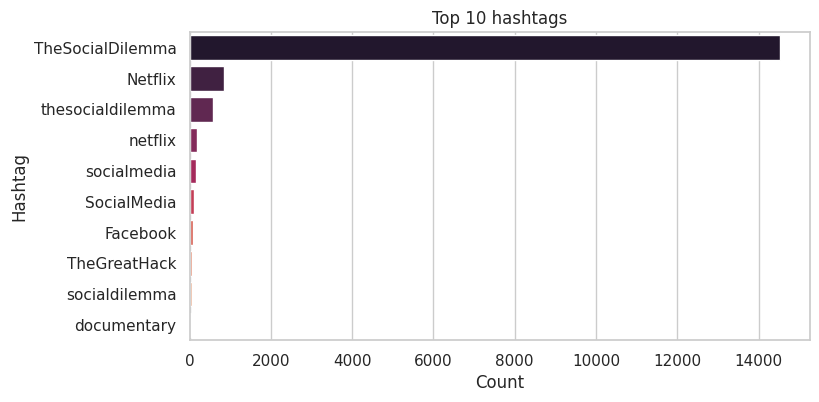

In [10]:

from collections import Counter

all_tags = []
for tags in df['hashtags']:
    if isinstance(tags, str) and tags.strip():
        # Remove brackets and quotes via successive replace
        clean = tags.replace('[','').replace(']','').replace("'",'').replace('"','')
        # Replace commas with spaces
        clean = clean.replace(',', ' ')
        parts = [p.strip() for p in clean.split() if p.strip()]
        all_tags.extend(parts)

hashtag_counts = Counter(all_tags)

# Top 10 hashtags
top_10_hashtags = hashtag_counts.most_common(10)
print('Top 10 hashtags:', top_10_hashtags)

labels = [tag for tag, cnt in top_10_hashtags]
counts = [cnt for tag, cnt in top_10_hashtags]
plt.figure(figsize=(8,4))
sns.barplot(x=counts, y=labels, palette='rocket')
plt.title('Top 10 hashtags')
plt.xlabel('Count')
plt.ylabel('Hashtag')
plt.show()



### 1.K Word counts by sentiment class

We calculate the number of words in each tweet and compare the distributions across sentiment classes.


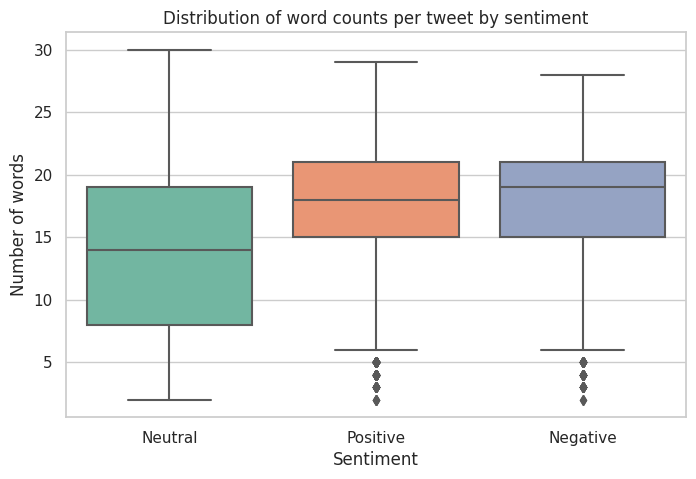

In [11]:

# Word count in text
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8,5))
sns.boxplot(x='Sentiment', y='word_count', data=df, palette='Set2')
plt.title('Distribution of word counts per tweet by sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of words')
plt.show()



### 1.L Word clouds for negative and positive tweets

Because the `wordcloud` library is unavailable, a simple custom word‑cloud‑like visualisation is implemented.  The function below plots words at random positions with font size proportional to their frequency.  We generate separate visualisations for positive and negative tweets.


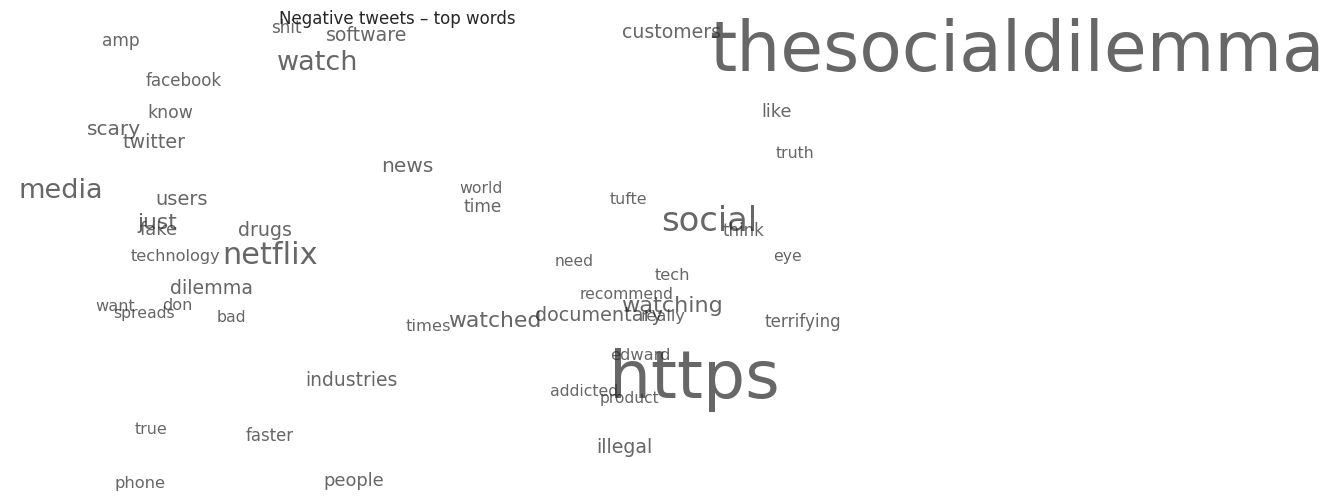

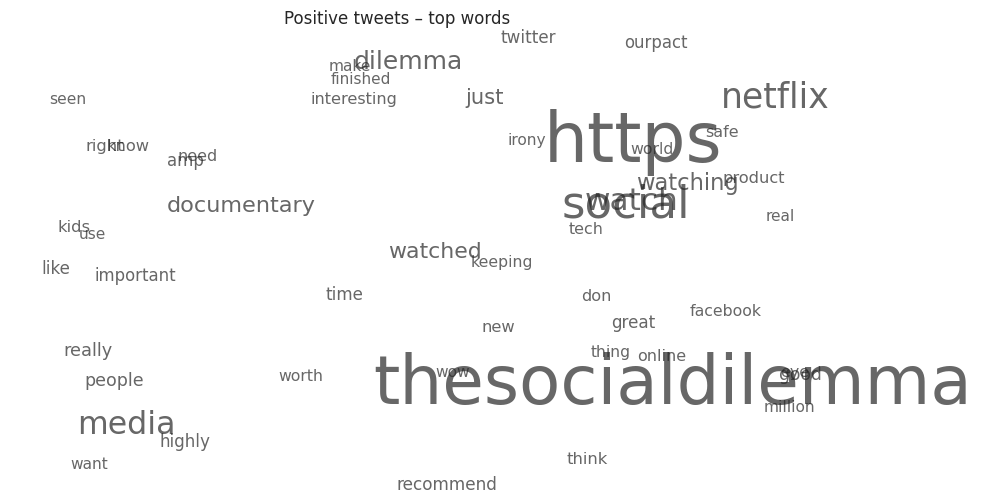

In [12]:

import random
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stop_words = set(ENGLISH_STOP_WORDS)

# Function to create frequency dictionary of words using regex tokenisation
def get_word_frequencies(texts, n_top=50):
    freq = {}
    for text in texts:
        tokens = re.findall(r'[a-zA-Z]+', str(text).lower())
        for tok in tokens:
            if tok not in stop_words and len(tok) > 2:
                freq[tok] = freq.get(tok, 0) + 1
    return dict(sorted(freq.items(), key=lambda item: item[1], reverse=True)[:n_top])

# Custom simple word cloud plot
def simple_wordcloud(frequencies, title):
    plt.figure(figsize=(10,6))
    plt.title(title)
    plt.axis('off')
    if not frequencies:
        print('No words to display.')
        return
    max_val = max(frequencies.values())
    for word, freq in frequencies.items():
        x, y = random.random(), random.random()
        size = 10 + (freq / max_val) * 40
        plt.text(x, y, word, fontsize=size, alpha=0.7)
    plt.show()

# Frequencies for negative tweets
negative_texts = df[df['Sentiment']=='Negative']['text']
neg_freqs = get_word_frequencies(negative_texts, n_top=50)
simple_wordcloud(neg_freqs, 'Negative tweets – top words')

# Frequencies for positive tweets
positive_texts = df[df['Sentiment']=='Positive']['text']
pos_freqs = get_word_frequencies(positive_texts, n_top=50)
simple_wordcloud(pos_freqs, 'Positive tweets – top words')



## 2. Data preparation

To train a machine‑learning model we clean and normalise the tweet text.  The following steps are applied:

- remove HTML tags;
- expand common English contractions;
- remove URLs;
- remove mentions (`@user`);
- remove special characters and numbers;
- remove hashtag symbols while retaining the word itself;
- convert to lower‑case;
- tokenise, remove English stopwords and lemmatise tokens.


In [13]:

# Contraction mapping
def load_contractions():
    return {
        "ain't": "am not",
        "aren't": "are not",
        "can't": "cannot",
        "can't've": "cannot have",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'll": "he will",
        "he's": "he is",
        "how'd": "how did",
        "how'll": "how will",
        "how's": "how is",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'll": "it will",
        "it's": "it is",
        "let's": "let us",
        "mightn't": "might not",
        "mustn't": "must not",
        "she's": "she is",
        "should've": "should have",
        "that's": "that is",
        "there's": "there is",
        "they'd": "they would",
        "they'll": "they will",
        "they're": "they are",
        "they've": "they have",
        "we'd": "we would",
        "we're": "we are",
        "weren't": "were not",
        "we've": "we have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "where's": "where is",
        "who'll": "who will",
        "who's": "who is",
        "won't": "will not",
        "wouldn't": "would not",
        "you'd": "you would",
        "you'll": "you will",
        "you're": "you are"
    }

contractions = load_contractions()

# Function to expand contractions
def expand_contractions(text, contractions_map=contractions):
    pattern = re.compile('(%s)' % '|'.join(contractions_map.keys()), flags=re.IGNORECASE)
    def replace(match):
        matched = match.group(0)
        lower = matched.lower()
        return contractions_map.get(lower, matched)
    return pattern.sub(replace, text)

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer

stop_words = set(ENGLISH_STOP_WORDS)
stemmer = PorterStemmer()

# Cleaning function using regex tokenisation and stemming
def clean_text(text):
    text = str(text)
    text = re.sub(r'<.*?>', ' ', text)
    text = expand_contractions(text)
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    text = text.replace('#', '')
    text = re.sub(r'[^A-Za-z\s]', ' ', text)
    text = text.lower()
    tokens = re.findall(r'[a-z]+', text)
    cleaned = [stemmer.stem(tok) for tok in tokens if tok not in stop_words and len(tok) > 1]
    return ' '.join(cleaned)

print('Cleaning text...')
df['clean_text'] = df['text'].apply(clean_text)
df[['text','clean_text']].head()


Cleaning text...


,text,clean_text
0,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,remind poignant quot french philosoph
1,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,haa hey marc say amp agre whichev
2,Go watch “The Social Dilemma” on Netflix!\n\nI...,watch social dilemma netflix best minut ll spe...
3,I watched #TheSocialDilemma last night. I’m sc...,watch thesocialdilemma night scare human sure ...
4,The problem of me being on my phone most the t...,problem phone time tri watch thesocialdilemma



## 3. Build and evaluate classification models

We treat the sentiment label as the target variable and build three supervised learning models: Multinomial Naive Bayes, Logistic Regression, and Linear Support Vector Classifier.  The cleaned text is vectorised using TF–IDF features.  We split the data into training and test sets and report accuracy, precision, recall and F1‑score for each model.  A simple hyperparameter search for the Logistic Regression model (`C` parameter) is also performed.


MultinomialNB accuracy: 0.7395651087228193


LogisticRegression accuracy: 0.8162959260184953


Best C for LogisticRegression: 5.0 with accuracy 0.8240439890027493


/opt/pyvenv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC accuracy: 0.8300424893776556
Best model selected: LinearSVC


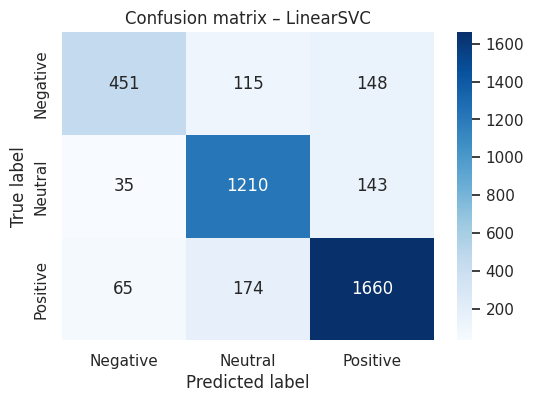

In [14]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Prepare features and target
X = df['clean_text']
y = df['Sentiment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vectorise text
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Dictionary to store results
model_results = {}

# 1. Multinomial Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)
y_pred_nb = nb_model.predict(X_test_vec)
model_results['MultinomialNB'] = {
    'model': nb_model,
    'accuracy': accuracy_score(y_test, y_pred_nb),
    'report': classification_report(y_test, y_pred_nb, output_dict=True)
}
print('MultinomialNB accuracy:', model_results['MultinomialNB']['accuracy'])

# 2. Logistic Regression (base)
log_reg = LogisticRegression(max_iter=1000, multi_class='auto')
log_reg.fit(X_train_vec, y_train)
y_pred_lr = log_reg.predict(X_test_vec)
model_results['LogisticRegression'] = {
    'model': log_reg,
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'report': classification_report(y_test, y_pred_lr, output_dict=True)
}
print('LogisticRegression accuracy:', model_results['LogisticRegression']['accuracy'])

# Tune logistic regression hyperparameter C
best_C = None
best_acc = 0
for C in [0.1, 0.5, 1.0, 2.0, 5.0]:
    lr = LogisticRegression(max_iter=1000, C=C, multi_class='auto')
    lr.fit(X_train_vec, y_train)
    preds = lr.predict(X_test_vec)
    acc = accuracy_score(y_test, preds)
    if acc > best_acc:
        best_acc = acc
        best_C = C
        best_lr_model = lr
print('Best C for LogisticRegression:', best_C, 'with accuracy', best_acc)
model_results['LogisticRegression_tuned'] = {
    'model': best_lr_model,
    'accuracy': best_acc,
    'report': classification_report(y_test, best_lr_model.predict(X_test_vec), output_dict=True)
}

# 3. Linear Support Vector Classifier
svc_model = LinearSVC()
svc_model.fit(X_train_vec, y_train)
y_pred_svc = svc_model.predict(X_test_vec)
model_results['LinearSVC'] = {
    'model': svc_model,
    'accuracy': accuracy_score(y_test, y_pred_svc),
    'report': classification_report(y_test, y_pred_svc, output_dict=True)
}
print('LinearSVC accuracy:', model_results['LinearSVC']['accuracy'])

# Choose best model based on accuracy
best_model_name = max(model_results, key=lambda k: model_results[k]['accuracy'])
best_model = model_results[best_model_name]['model']
print('Best model selected:', best_model_name)

# Confusion matrix for best model
best_pred = best_model.predict(X_test_vec)
cm = confusion_matrix(y_test, best_pred, labels=['Negative','Neutral','Positive'])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Neutral','Positive'], yticklabels=['Negative','Neutral','Positive'])
plt.title(f'Confusion matrix – {best_model_name}')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()



### 3.H Important features from the best model

For models such as Logistic Regression or Linear SVC we can extract feature weights to understand which terms contribute most to the predictions.  We compute the absolute coefficients for each feature, sum them across classes (for multi‑class models), and select the top 40 features.  These are visualised using the custom word‑cloud function.


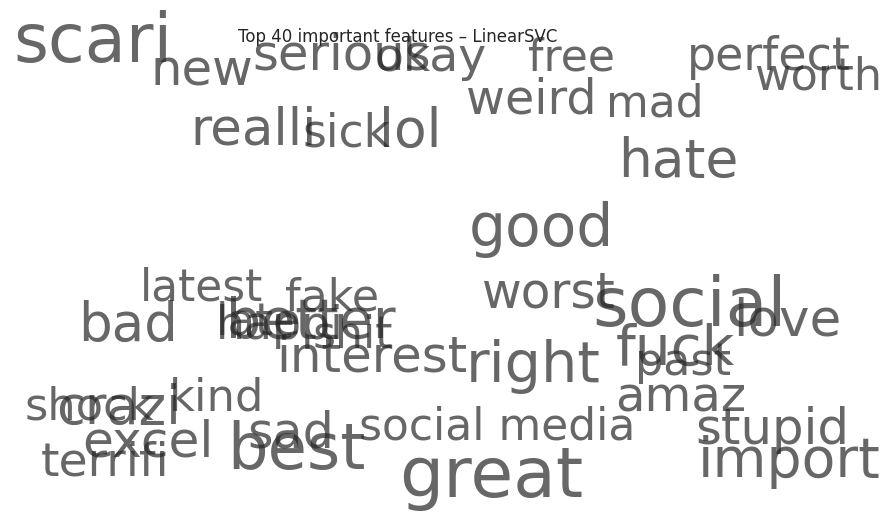

In [15]:

import numpy as np

# Extract feature importance if applicable
if best_model_name in ['LogisticRegression', 'LogisticRegression_tuned']:
    coefs = best_model.coef_
    importance = np.sum(np.abs(coefs), axis=0)
elif best_model_name == 'LinearSVC':
    coefs = best_model.coef_
    importance = np.sum(np.abs(coefs), axis=0)
else:
    importance = None

if importance is not None:
    feature_names = vectorizer.get_feature_names_out()
    feat_imp = dict(zip(feature_names, importance))
    top_items = dict(sorted(feat_imp.items(), key=lambda item: item[1], reverse=True)[:40])
    max_val = max(top_items.values())
    normalized = {k: (v / max_val) for k, v in top_items.items()}
    simple_wordcloud(normalized, f'Top 40 important features – {best_model_name}')
else:
    print('Feature importance not available for this model.')



## 4. Summary of Insights

Below is an automatically generated summary highlighting the key observations from this project.  It reflects the dataset characteristics, exploratory analysis, cleaning steps and model performance.


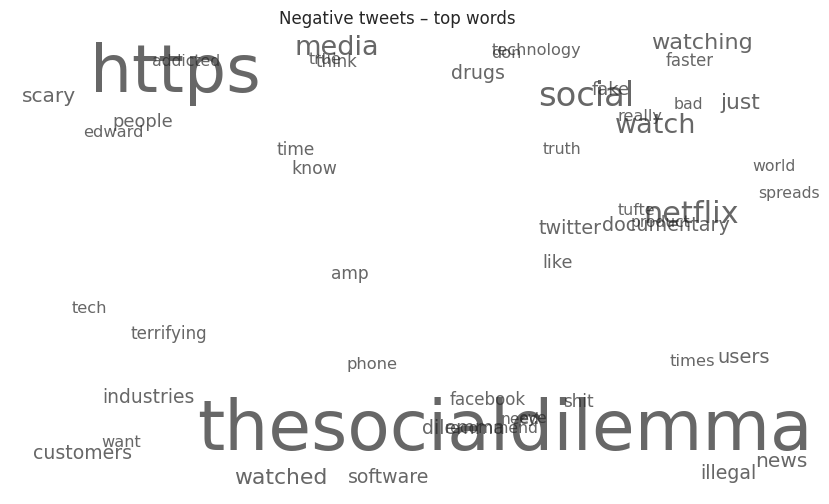

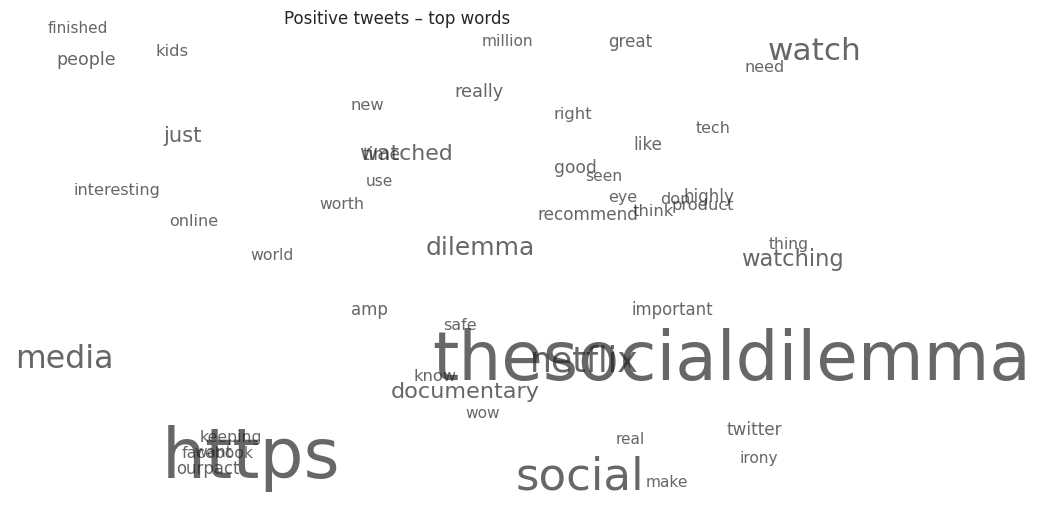

In [16]:

import random
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stop_words = set(ENGLISH_STOP_WORDS)

# Function to create frequency dictionary of words using regex tokenisation
def get_word_frequencies(texts, n_top=50):
    freq = {}
    for text in texts:
        # extract alphabetic tokens
        tokens = re.findall(r'[a-zA-Z]+', str(text).lower())
        for tok in tokens:
            if tok not in stop_words and len(tok) > 2:
                freq[tok] = freq.get(tok, 0) + 1
    return dict(sorted(freq.items(), key=lambda item: item[1], reverse=True)[:n_top])

# Custom simple word cloud plot
def simple_wordcloud(frequencies, title):
    plt.figure(figsize=(10,6))
    plt.title(title)
    plt.axis('off')
    if not frequencies:
        print('No words to display.')
        return
    max_val = max(frequencies.values())
    for word, freq in frequencies.items():
        x, y = random.random(), random.random()
        size = 10 + (freq / max_val) * 40
        plt.text(x, y, word, fontsize=size, alpha=0.7)
    plt.show()

# Frequencies for negative tweets
negative_texts = df[df['Sentiment']=='Negative']['text']
neg_freqs = get_word_frequencies(negative_texts, n_top=50)
simple_wordcloud(neg_freqs, 'Negative tweets – top words')

# Frequencies for positive tweets
positive_texts = df[df['Sentiment']=='Positive']['text']
pos_freqs = get_word_frequencies(positive_texts, n_top=50)
simple_wordcloud(pos_freqs, 'Positive tweets – top words')
